# NIFTY50 Daily Return Stock and Sector Correlation Analysis

<font color='red'> Important Note! The stock data used in this study is obtained using free data source. As such the stock prices are not adjusted for stock splits and dividends. This will result in incorrect results. If adjusted closed prices are obtained, the same pipeline presented below can be used with correct data. </font>

## Imports

In [59]:
import numpy as np
import pandas as pd

import datetime
from datetime import date, timedelta

from nsepy import get_history

import seaborn as sns
import matplotlib.pyplot as plt

import os

import scipy.stats as stats

%matplotlib inline

# Stock wise correlation

In [60]:
last_weeks = 52*7

#ending date for stock price fetching
end_date = date.today()

#Calculate date 52 weeks prior to today
start_date = end_date - timedelta(last_weeks)

In [61]:
# NSE provides a handy csv file with all the company names, their stock prices and symbols
# that we can parse to fetch the stock prices

# https://www.nseindia.com/products/content/equities/indices/nifty_next_50.htm
# Every time the ind_nifty50list.csv is updated, the NIFTY_stock_data.csv must be deleted
nifty50 = pd.read_csv('ind_nifty50list.csv')

In [62]:
nifty50.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,SERVICES,ADANIPORTS,EQ,INE742F01042
1,Asian Paints Ltd.,CONSUMER GOODS,ASIANPAINT,EQ,INE021A01026
2,Axis Bank Ltd.,FINANCIAL SERVICES,AXISBANK,EQ,INE238A01034
3,Bajaj Auto Ltd.,AUTOMOBILE,BAJAJ-AUTO,EQ,INE917I01010
4,Bajaj Finance Ltd.,FINANCIAL SERVICES,BAJFINANCE,EQ,INE296A01024


## Fetch Stock Prices

In [63]:
# if the file does not exist, fetch prices and create it
if not os.path.isfile('NIFTY_stock_data.csv'):
    
    stock_price_dataframe = pd.DataFrame()
    
    for stock in nifty50['Symbol']:
        stock_price_dataframe[stock] = get_history(symbol=stock, start=start_date, end=end_date)['Close']
        
    #change date before saving
    stock_price_dataframe.index = pd.to_datetime(stock_price_dataframe.index, format = '%Y-%m-%d').strftime('%d-%m-%Y')
    
    print('Downloading stock prices from {} to {}.'.format(start_date, end_date))
    
    stock_price_dataframe.to_csv('NIFTY_stock_data.csv', mode='a', sep=',', index_label='Date')

# if the file exists, append new prices till today
else:    
    #Find the date range between which the stock data need to be appended
    temporary_dataframe = pd.read_csv('NIFTY_stock_data.csv', index_col='Date')

    date_str = temporary_dataframe.iloc[-1].name
    format_str = '%d-%m-%Y' # The format

    last_updated_date = datetime.datetime.strptime(date_str, format_str).date()
    today_date = date.today()

    continue_date = last_updated_date + timedelta(1)
    yesterday_date = today_date - timedelta(1)
    
    
    updated_stock_price_dataframe = pd.DataFrame()
    # only download new data if last date is not the same as current date
    if last_updated_date != yesterday_date:
        print('Downloading and updating stock prices from {} to {}.'.format(continue_date, yesterday_date))
        
        for stock in nifty50['Symbol']:
            updated_stock_price_dataframe[stock] = get_history(symbol=stock, start=continue_date, end=yesterday_date)['Close']
        
        # change date before saving
        updated_stock_price_dataframe.index = pd.to_datetime(updated_stock_price_dataframe.index, format = '%Y-%m-%d').strftime('%d-%m-%Y')
        
        updated_stock_price_dataframe.to_csv('NIFTY_stock_data.csv', mode='a', sep=',', header=False)
    else:
        print('Data is current, No update needed') 
        
stocks_close_price = pd.read_csv('NIFTY_stock_data.csv')

In [64]:
# Ensure only last 52 week prices are loaded in case there are more prices
if len(stocks_close_price) >= (last_weeks):
    stocks_close_price = stocks_close_price.iloc[-last_weeks: , :]

In [65]:
stocks_close_price.head()

,Date,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
0,30-10-2017,429.80,1182.55,484.00,3282.20,1804.30,4994.85,536.25,492.90,429.70,...,436.55,718.25,485.55,618.30,824.40,4472.25,340.95,293.25,314.85,549.00
1,31-10-2017,430.35,1180.85,523.15,3257.10,1800.60,5010.35,541.60,497.20,442.15,...,428.40,703.80,482.05,635.25,799.30,4401.05,331.85,294.05,314.25,541.90
2,01-11-2017,433.10,1175.95,535.10,3239.75,1806.75,5022.60,539.80,539.10,426.55,...,437.75,707.30,488.50,637.45,782.05,4426.30,343.35,293.55,318.80,535.80
3,02-11-2017,437.25,1178.40,532.15,3241.10,1810.20,4982.15,542.85,543.20,418.65,...,434.90,706.10,467.95,655.15,779.30,4399.15,340.80,293.25,320.45,529.25
4,03-11-2017,434.85,1172.45,540.10,3217.45,1836.95,5032.60,533.10,541.25,413.75,...,447.70,708.90,463.45,659.75,775.60,4375.10,338.10,294.55,325.95,538.95


In [66]:
# Run this for percent change coorelation

stocks_close_price_dpc = pd.DataFrame()

# calculate daily percentage return
for stock in nifty50['Symbol']:
    stocks_close_price_dpc[stock] = stocks_close_price[stock].pct_change(1)

In [67]:
stocks_close_price_dpc.describe()

# notice the mean return is almost zero

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,...,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
mean,-0.000431,0.000665,0.001055,-0.000424,0.001505,0.001023,-0.000922,-0.001418,-0.001627,-0.000530,...,-0.002955,-0.000930,0.001453,0.001538,-0.000164,-0.000289,-0.001619,0.000426,-0.001360,-0.000595
std,0.019088,0.014240,0.019008,0.015803,0.021590,0.018662,0.025567,0.021952,0.016846,0.017102,...,0.021484,0.020221,0.019299,0.021090,0.021989,0.015366,0.022620,0.013821,0.032042,0.015658
min,-0.069833,-0.051608,-0.047065,-0.088411,-0.071519,-0.061981,-0.198852,-0.066247,-0.060912,-0.072558,...,-0.131858,-0.091255,-0.070004,-0.078729,-0.067091,-0.048276,-0.107490,-0.040658,-0.290414,-0.078011
25%,-0.011090,-0.007572,-0.010855,-0.008901,-0.010339,-0.010385,-0.013605,-0.013957,-0.011506,-0.009637,...,-0.012946,-0.013660,-0.010246,-0.009072,-0.013624,-0.009975,-0.014425,-0.006208,-0.013022,-0.010698
50%,-0.000185,-0.000947,-0.000368,-0.000338,0.001446,0.001287,-0.000632,-0.002996,-0.001104,-0.001666,...,-0.002528,0.000316,0.001104,0.000431,-0.001072,-0.000359,-0.002433,0.000420,-0.000721,-0.000140
75%,0.009505,0.007855,0.010849,0.007968,0.012525,0.010330,0.013599,0.008297,0.008867,0.007009,...,0.008273,0.011459,0.013777,0.010734,0.011498,0.010913,0.012594,0.008031,0.011820,0.008308
max,0.073331,0.056459,0.092051,0.053176,0.109655,0.098064,0.066678,0.104757,0.050868,0.076241,...,0.060463,0.063054,0.085827,0.187874,0.150109,0.038410,0.070766,0.053810,0.093656,0.062384


In [68]:
stocks_close_price_dpc.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.001280,-0.001438,0.080888,-0.007647,-0.002051,0.003103,0.009977,0.008724,0.028974,0.002476,...,-0.018669,-0.020118,-0.007208,0.027414,-0.030446,-0.015920,-0.026690,0.002728,-0.001906,-0.012933
2,0.006390,-0.004150,0.022842,-0.005327,0.003416,0.002445,-0.003323,0.084272,-0.035282,-0.001354,...,0.021825,0.004973,0.013380,0.003463,-0.021581,0.005737,0.034654,-0.001700,0.014479,-0.011257
3,0.009582,0.002083,-0.005513,0.000417,0.001910,-0.008054,0.005650,0.007605,-0.018521,0.014759,...,-0.006511,-0.001697,-0.042068,0.027767,-0.003516,-0.006134,-0.007427,-0.001022,0.005176,-0.012225
4,-0.005489,-0.005049,0.014939,-0.007297,0.014777,0.010126,-0.017961,-0.003590,-0.011704,0.006447,...,0.029432,0.003965,-0.009616,0.007021,-0.004748,-0.005467,-0.007923,0.004433,0.017163,0.018328


In [69]:
# delete the first row since it has no percentage return data
daily_percent_change = stocks_close_price_dpc.iloc[1:]

In [70]:
daily_percent_change.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
1,0.001280,-0.001438,0.080888,-0.007647,-0.002051,0.003103,0.009977,0.008724,0.028974,0.002476,...,-0.018669,-0.020118,-0.007208,0.027414,-0.030446,-0.015920,-0.026690,0.002728,-0.001906,-0.012933
2,0.006390,-0.004150,0.022842,-0.005327,0.003416,0.002445,-0.003323,0.084272,-0.035282,-0.001354,...,0.021825,0.004973,0.013380,0.003463,-0.021581,0.005737,0.034654,-0.001700,0.014479,-0.011257
3,0.009582,0.002083,-0.005513,0.000417,0.001910,-0.008054,0.005650,0.007605,-0.018521,0.014759,...,-0.006511,-0.001697,-0.042068,0.027767,-0.003516,-0.006134,-0.007427,-0.001022,0.005176,-0.012225
4,-0.005489,-0.005049,0.014939,-0.007297,0.014777,0.010126,-0.017961,-0.003590,-0.011704,0.006447,...,0.029432,0.003965,-0.009616,0.007021,-0.004748,-0.005467,-0.007923,0.004433,0.017163,0.018328
5,0.006209,-0.008614,-0.010368,-0.002362,-0.008138,-0.004570,-0.016695,-0.016074,0.024894,0.022965,...,0.033951,-0.002962,-0.006473,0.187874,-0.017664,0.012034,0.002366,0.017994,-0.019328,-0.015493


In [71]:
daily_percent_change.set_index(stocks_close_price['Date'][1:], inplace=True)

In [72]:
daily_percent_change.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
31-10-2017,0.001280,-0.001438,0.080888,-0.007647,-0.002051,0.003103,0.009977,0.008724,0.028974,0.002476,...,-0.018669,-0.020118,-0.007208,0.027414,-0.030446,-0.015920,-0.026690,0.002728,-0.001906,-0.012933
01-11-2017,0.006390,-0.004150,0.022842,-0.005327,0.003416,0.002445,-0.003323,0.084272,-0.035282,-0.001354,...,0.021825,0.004973,0.013380,0.003463,-0.021581,0.005737,0.034654,-0.001700,0.014479,-0.011257
02-11-2017,0.009582,0.002083,-0.005513,0.000417,0.001910,-0.008054,0.005650,0.007605,-0.018521,0.014759,...,-0.006511,-0.001697,-0.042068,0.027767,-0.003516,-0.006134,-0.007427,-0.001022,0.005176,-0.012225
03-11-2017,-0.005489,-0.005049,0.014939,-0.007297,0.014777,0.010126,-0.017961,-0.003590,-0.011704,0.006447,...,0.029432,0.003965,-0.009616,0.007021,-0.004748,-0.005467,-0.007923,0.004433,0.017163,0.018328
06-11-2017,0.006209,-0.008614,-0.010368,-0.002362,-0.008138,-0.004570,-0.016695,-0.016074,0.024894,0.022965,...,0.033951,-0.002962,-0.006473,0.187874,-0.017664,0.012034,0.002366,0.017994,-0.019328,-0.015493


# Demonstrate normal distribution of daily percentage returns

Contrary to the popular belief, stock price returns are normally distributed due to the random walk

C:\Users\manuj\Anaconda3\envs\env_finance\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


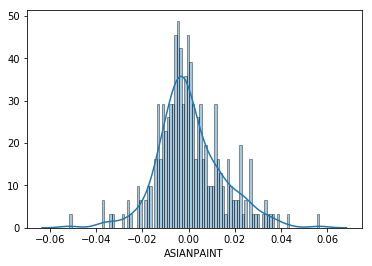

In [73]:
plt.rcParams["patch.force_edgecolor"] = True

'''
Kernal dies!
pairs_plot = sns.pairplot(daily_percent_change, kind="reg")

pairs_plot.savefig("NIFTY50PairsPlot.png", dpi=300)'''

sns.distplot(daily_percent_change['ASIANPAINT'], bins=100);

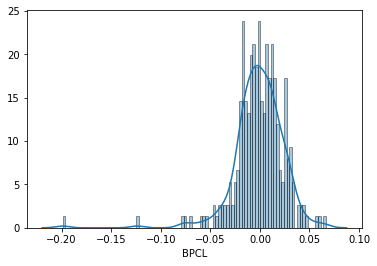

In [74]:
sns.distplot(daily_percent_change['BPCL'], bins=100);

# Test for independence

In [75]:
daily_percent_change_normalized = stocks_close_price.copy()

In [76]:
daily_percent_change_normalized.set_index(daily_percent_change_normalized['Date'], inplace=True)
daily_percent_change_normalized.drop('Date', axis=1, inplace=True)

In [77]:
daily_percent_change_normalized.describe()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
count,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,...,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000,285.000000
mean,381.616842,1240.026316,562.058947,2912.553860,2110.145263,5663.121930,408.518596,398.544211,315.715789,595.965789,...,307.670351,614.434561,639.096667,867.831404,707.257193,4049.543684,264.394912,296.329474,305.033684,534.237193
std,29.902889,97.157427,41.313961,233.757441,383.588799,627.359619,70.950561,70.023732,44.939441,41.008716,...,85.523141,70.834880,82.447019,64.451920,56.008581,245.157599,48.336556,22.229335,60.306469,51.760097
min,301.800000,1101.600000,484.000000,2475.150000,1596.450000,4812.350000,257.200000,285.350000,249.200000,512.550000,...,157.100000,498.650000,460.450000,618.300000,549.600000,3343.650000,192.550000,255.250000,160.450000,414.050000
25%,366.900000,1153.000000,532.550000,2732.800000,1756.300000,5129.750000,365.050000,360.500000,279.600000,569.800000,...,252.600000,566.000000,603.150000,818.900000,665.800000,3881.300000,219.650000,279.450000,303.250000,493.700000
50%,381.150000,1222.550000,548.500000,2857.950000,2077.400000,5429.100000,401.600000,382.050000,313.800000,603.450000,...,308.000000,590.350000,657.400000,872.150000,718.350000,4069.350000,252.650000,293.450000,316.600000,554.100000
75%,402.500000,1312.150000,597.350000,3143.500000,2383.300000,6042.250000,469.800000,430.250000,343.950000,625.800000,...,375.800000,677.750000,697.500000,917.600000,747.950000,4240.550000,309.350000,317.200000,343.150000,575.450000
max,448.750000,1467.750000,660.050000,3412.950000,2985.500000,7116.600000,542.850000,543.200000,442.150000,672.800000,...,462.900000,783.500000,775.050000,997.600000,824.400000,4545.100000,345.600000,340.700000,394.000000,613.400000


In [78]:
daily_percent_change_normalized.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
30-10-2017,429.80,1182.55,484.00,3282.20,1804.30,4994.85,536.25,492.90,429.70,626.05,...,436.55,718.25,485.55,618.30,824.40,4472.25,340.95,293.25,314.85,549.00
31-10-2017,430.35,1180.85,523.15,3257.10,1800.60,5010.35,541.60,497.20,442.15,627.60,...,428.40,703.80,482.05,635.25,799.30,4401.05,331.85,294.05,314.25,541.90
01-11-2017,433.10,1175.95,535.10,3239.75,1806.75,5022.60,539.80,539.10,426.55,626.75,...,437.75,707.30,488.50,637.45,782.05,4426.30,343.35,293.55,318.80,535.80
02-11-2017,437.25,1178.40,532.15,3241.10,1810.20,4982.15,542.85,543.20,418.65,636.00,...,434.90,706.10,467.95,655.15,779.30,4399.15,340.80,293.25,320.45,529.25
03-11-2017,434.85,1172.45,540.10,3217.45,1836.95,5032.60,533.10,541.25,413.75,640.10,...,447.70,708.90,463.45,659.75,775.60,4375.10,338.10,294.55,325.95,538.95


In [79]:
# Normalize the Data
for stock in nifty50['Symbol']:
    daily_percent_change_normalized[stock] = \
    daily_percent_change_normalized[stock].apply(lambda x: x / daily_percent_change_normalized[stock][0])

In [80]:
daily_percent_change_normalized.head()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
30-10-2017,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
31-10-2017,1.001280,0.998562,1.080888,0.992353,0.997949,1.003103,1.009977,1.008724,1.028974,1.002476,...,0.981331,0.979882,0.992792,1.027414,0.969554,0.984080,0.973310,1.002728,0.998094,0.987067
01-11-2017,1.007678,0.994419,1.105579,0.987067,1.001358,1.005556,1.006620,1.093731,0.992669,1.001118,...,1.002749,0.984755,1.006076,1.030972,0.948629,0.989726,1.007039,1.001023,1.012546,0.975956
02-11-2017,1.017334,0.996491,1.099483,0.987478,1.003270,0.997457,1.012308,1.102049,0.974284,1.015893,...,0.996220,0.983084,0.963752,1.059599,0.945294,0.983655,0.999560,1.000000,1.017786,0.964026
03-11-2017,1.011750,0.991459,1.115909,0.980272,1.018096,1.007558,0.994126,1.098093,0.962881,1.022442,...,1.025541,0.986982,0.954485,1.067039,0.940805,0.978277,0.991641,1.004433,1.035255,0.981694


In [81]:
daily_percent_change_normalized.tail()

,ADANIPORTS,ASIANPAINT,AXISBANK,BAJAJ-AUTO,BAJFINANCE,BAJAJFINSV,BPCL,BHARTIARTL,INFRATEL,CIPLA,...,TATAMOTORS,TATASTEEL,TECHM,TITAN,UPL,ULTRACEMCO,VEDL,WIPRO,YESBANK,ZEEL
Date,,,,,,,,,,,,,,,,,,,,,
17-12-2018,0.864123,1.129635,1.275103,0.865563,1.371391,1.218815,0.653333,0.639481,0.593321,0.836435,...,0.398465,0.729551,1.482340,1.512696,0.931647,0.896484,0.602728,1.158056,0.574877,0.914117
18-12-2018,0.867613,1.146421,1.279752,0.865547,1.403425,1.231799,0.658741,0.644756,0.592506,0.835237,...,0.400298,0.733728,1.460200,1.508976,0.902050,0.896227,0.611673,1.142540,0.568525,0.842805
19-12-2018,0.874477,1.184094,1.325723,0.872281,1.439284,1.282411,0.674592,0.654697,0.613102,0.838192,...,0.398351,0.734285,1.461127,1.502830,0.916667,0.913310,0.606687,1.161807,0.570272,0.847268
20-12-2018,0.872848,1.205700,1.307748,0.879654,1.436236,1.282311,0.692028,0.642220,0.609728,0.831004,...,0.404077,0.728646,1.457625,1.498868,0.934013,0.903427,0.594662,1.136402,0.593140,0.841439
21-12-2018,0.840158,1.173904,1.282748,0.855661,1.436153,1.273332,0.698648,0.624670,0.604724,0.825254,...,0.403734,0.724260,1.432911,1.455685,0.892346,0.890894,0.586743,1.098380,0.581070,0.815665


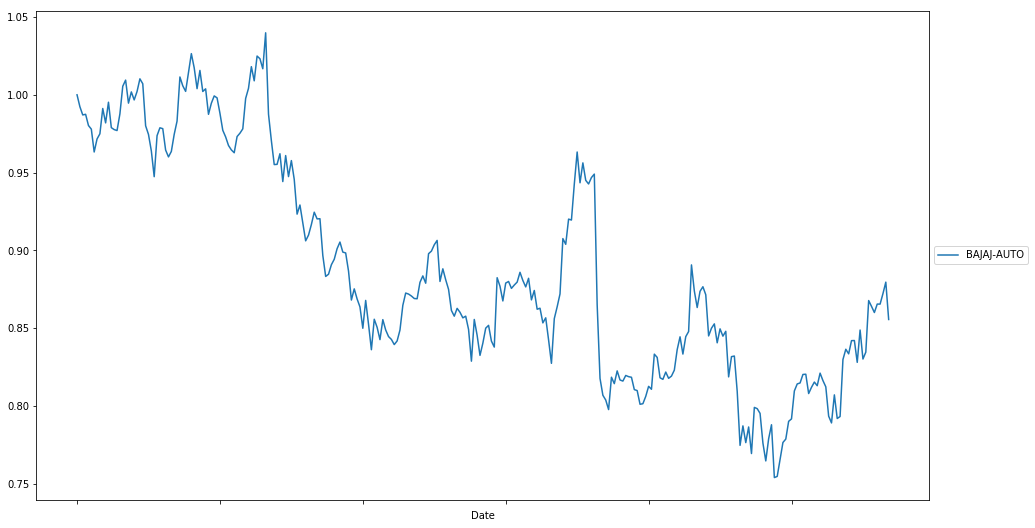

In [84]:
plot_returns = daily_percent_change_normalized['BAJAJ-AUTO'].plot(figsize=(16,9));
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

$H_0$: Stock prices are independent

$H_1$ : Stock prices are not independent

In [24]:
# Confidence Interval Based Approach

probability = 0.95

Chi_Statistic, p_value, dof, expected_frequency = stats.chi2_contingency(observed = daily_percent_change_normalized)

# For specific pair use
# Chi_Statistic, p_value, dof, expected_frequency = stats.chi2_contingency(observed = daily_percent_change_normalized[["BPCL", "HINDPETRO"]])

critical_value = stats.chi2.ppf(q = probability, # Find the critical value for 95% confidence*
                      df = dof)

p_value = 1 - stats.chi2.cdf(x=Chi_Statistic,  # Find the p-value
                             df=dof)

print("\nExpected Frequency")
print(expected_frequency)

print("\nChi Statistic")
print(Chi_Statistic)

print("\nCritical value")
print(critical_value)

print("\nDOF")
print(dof)

print("\nP value")
print(round(p_value, 3))

# interpret p-value
alpha = 1.0 - probability

if p_value <= alpha:
    print('\nDependent (reject H0) at {}% confidence level'.format(probability*100))
else:
    print('\nIndependent (fail to reject H0) at {}% confidence level'.format(probability*100))


Expected Frequency
[[0.92592549 1.08993272 1.20677768 ... 1.04960964 1.01997306 1.01691941]
 [0.92448911 1.08824191 1.2049056  ... 1.04798138 1.01839078 1.01534186]
 [0.92902335 1.0935793  1.21081518 ... 1.05312131 1.02338558 1.02032171]
 ...
 [0.8098641  0.95331362 1.05551248 ... 0.91804489 0.89212315 0.88945226]
 [0.81774225 0.96258721 1.06578023 ... 0.92697539 0.90080149 0.89810462]
 [0.8339483  0.9816638  1.08690191 ... 0.94534623 0.91865361 0.9159033 ]]

Chi Statistic
205.78844031502527

Critical value
13845.139050695863

DOF
13573

P value
1.0

Independent (fail to reject H0) at 95.0% confidence level


# Stock wise correlation

Wall time: 12.5 s


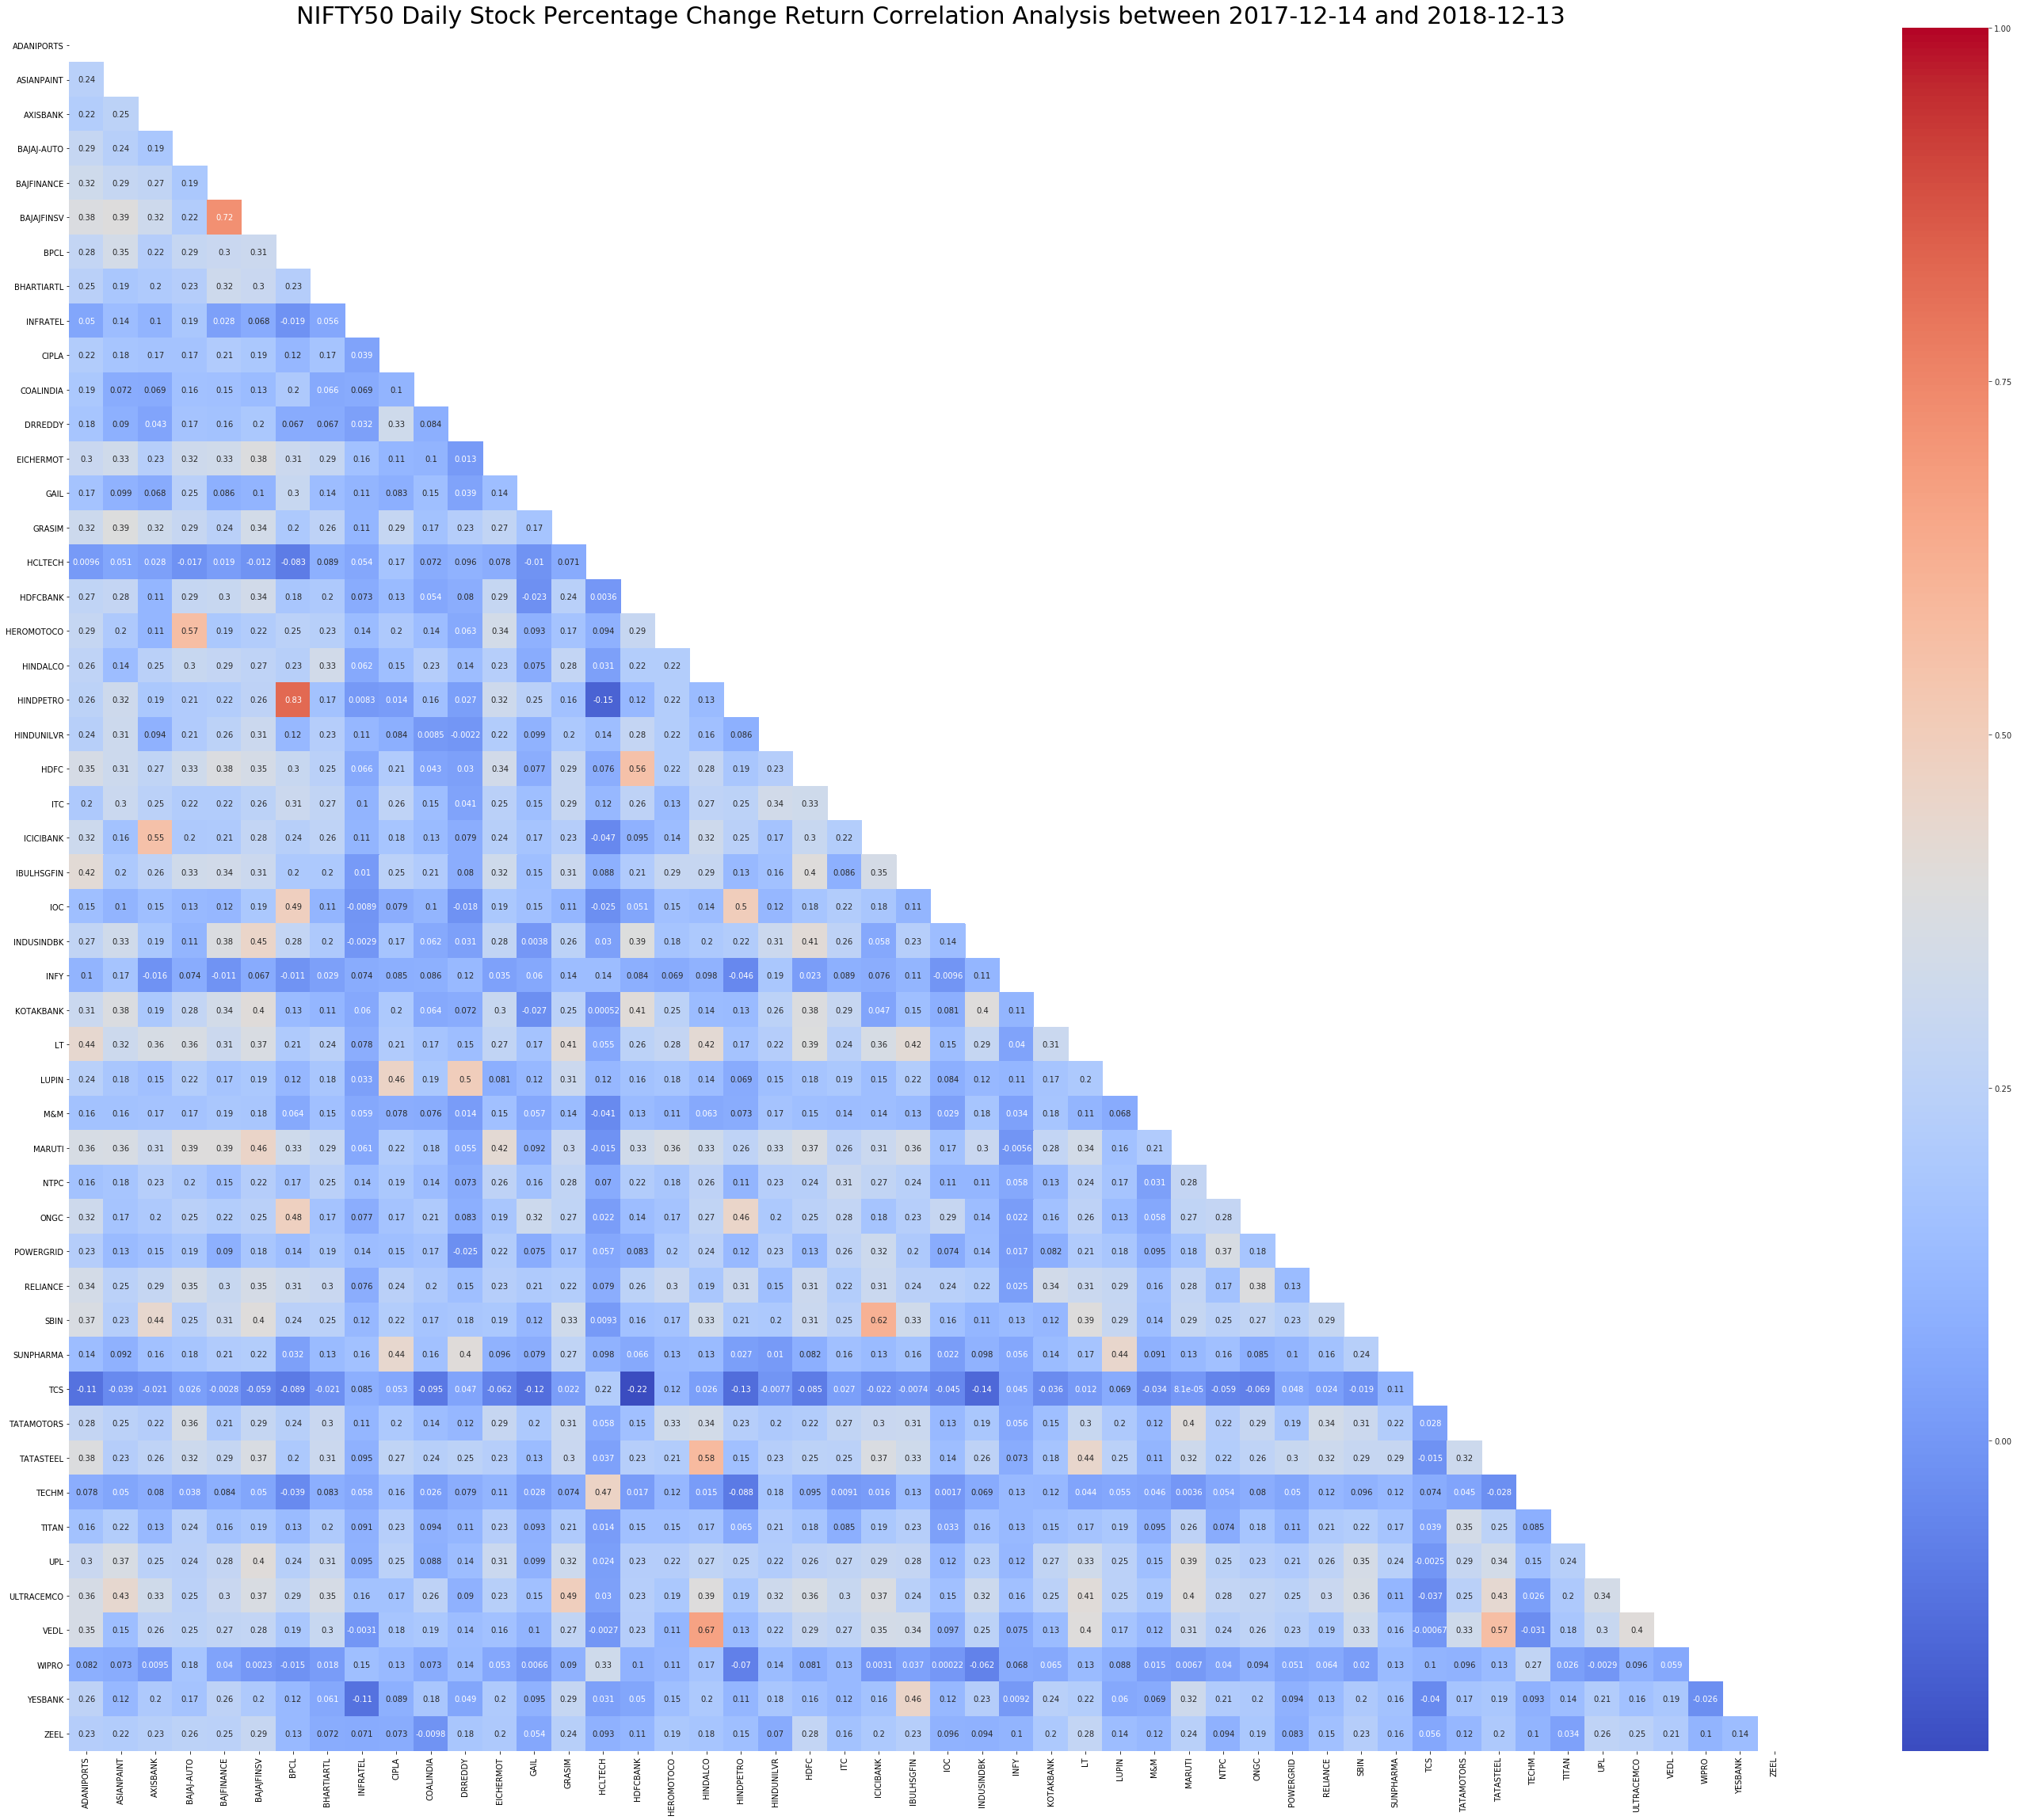

In [25]:
%%time
fig, ax = plt.subplots(figsize=(50,40)) # figsize in inches

ax.set_title("NIFTY50 Daily Stock Percentage Change Return Correlation Analysis between {start} and {end}".format(start=start_date, end=end_date), fontsize=30)

daily_percent_change_corr = daily_percent_change.corr()

# create a mask to cull upper diagonal half of the matrix since its a mirror image of lower diagonal half 
mask = np.zeros_like(daily_percent_change_corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(daily_percent_change_corr, annot=True, cmap="coolwarm", mask=mask, square=True)

fig.savefig("NIFTY50CorrelationMatrix.png", dpi=300)

In [26]:
# visualize the mask for debugging purposes
#mask

C:\Users\manuj\Anaconda3\envs\workPy\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


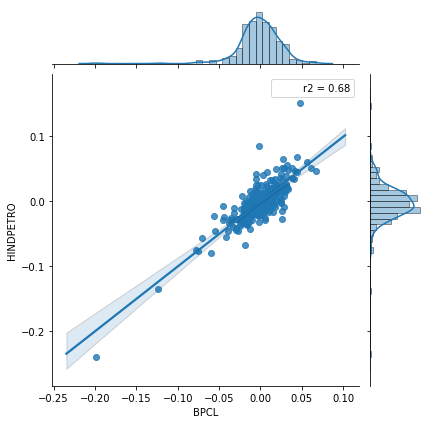

In [34]:
# verify BPCL and HINDPETRO linearity assumption to validate correlation results

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot("BPCL", "HINDPETRO", data=daily_percent_change, kind="reg", stat_func=r2);

C:\Users\manuj\Anaconda3\envs\workPy\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


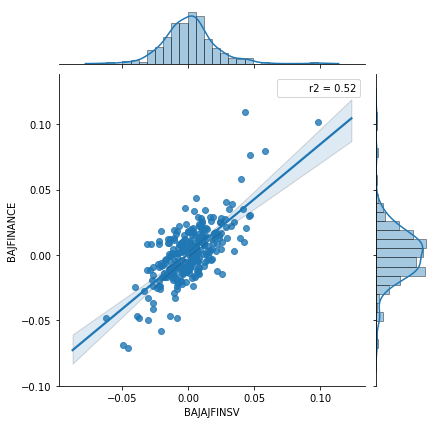

In [35]:
sns.jointplot("BAJAJFINSV", "BAJFINANCE", data=daily_percent_change, kind="reg", stat_func=r2);

# Sector wise correlation

In [29]:
# Find the indsustries that comprise of NIFTY50
nifty50['Industry'].unique()

array(['SERVICES', 'CONSUMER GOODS', 'FINANCIAL SERVICES', 'AUTOMOBILE',
       'ENERGY', 'TELECOM', 'PHARMA', 'METALS',
       'CEMENT & CEMENT PRODUCTS', 'IT', 'CONSTRUCTION',
       'FERTILISERS & PESTICIDES', 'MEDIA & ENTERTAINMENT'], dtype=object)

In [30]:
# create daily percentage change retrun for each industry

industry_data_frame = pd.DataFrame()

for industry in nifty50['Industry'].unique():
    # create a filter for the industry
    filter_symbol = nifty50['Industry'] == industry
    
    # get all the symbols for that industry
    industry_symbols = nifty50[filter_symbol]['Symbol']
    
    # get all the stock prices for that industry in one dataframe
    industry_stocks_percent_change = daily_percent_change.loc[:, industry_symbols]
    
    # create a sum column and add the returns by all companies in that industry per day
    industry_stocks_percent_change['Sum'] = industry_stocks_percent_change.sum(axis=1)
    
    # add each industry's return to a column in a dataframe
    industry_data_frame[industry] = industry_stocks_percent_change['Sum']

In [31]:
print(industry_data_frame.head())

            SERVICES  CONSUMER GOODS  FINANCIAL SERVICES  AUTOMOBILE  \
Date                                                                   
31-10-2017  0.001280        0.030684            0.042710   -0.045993   
01-11-2017  0.006390        0.031540            0.177884   -0.024148   
02-11-2017  0.009582        0.001170           -0.034855   -0.034078   
03-11-2017 -0.005489       -0.000580            0.117496    0.008426   
06-11-2017  0.006209        0.178263           -0.037794    0.064485   

              ENERGY   TELECOM    PHARMA    METALS  CEMENT & CEMENT PRODUCTS  \
Date                                                                           
31-10-2017 -0.018336  0.037698 -0.000083 -0.076519                  0.008028   
01-11-2017 -0.000605  0.048990 -0.039309  0.069520                  0.022199   
02-11-2017  0.010369 -0.010915  0.098180 -0.009242                  0.030866   
03-11-2017 -0.031854 -0.015294 -0.024827 -0.026942                 -0.009758   
06-11-2017 -0.0

Wall time: 9.81 s


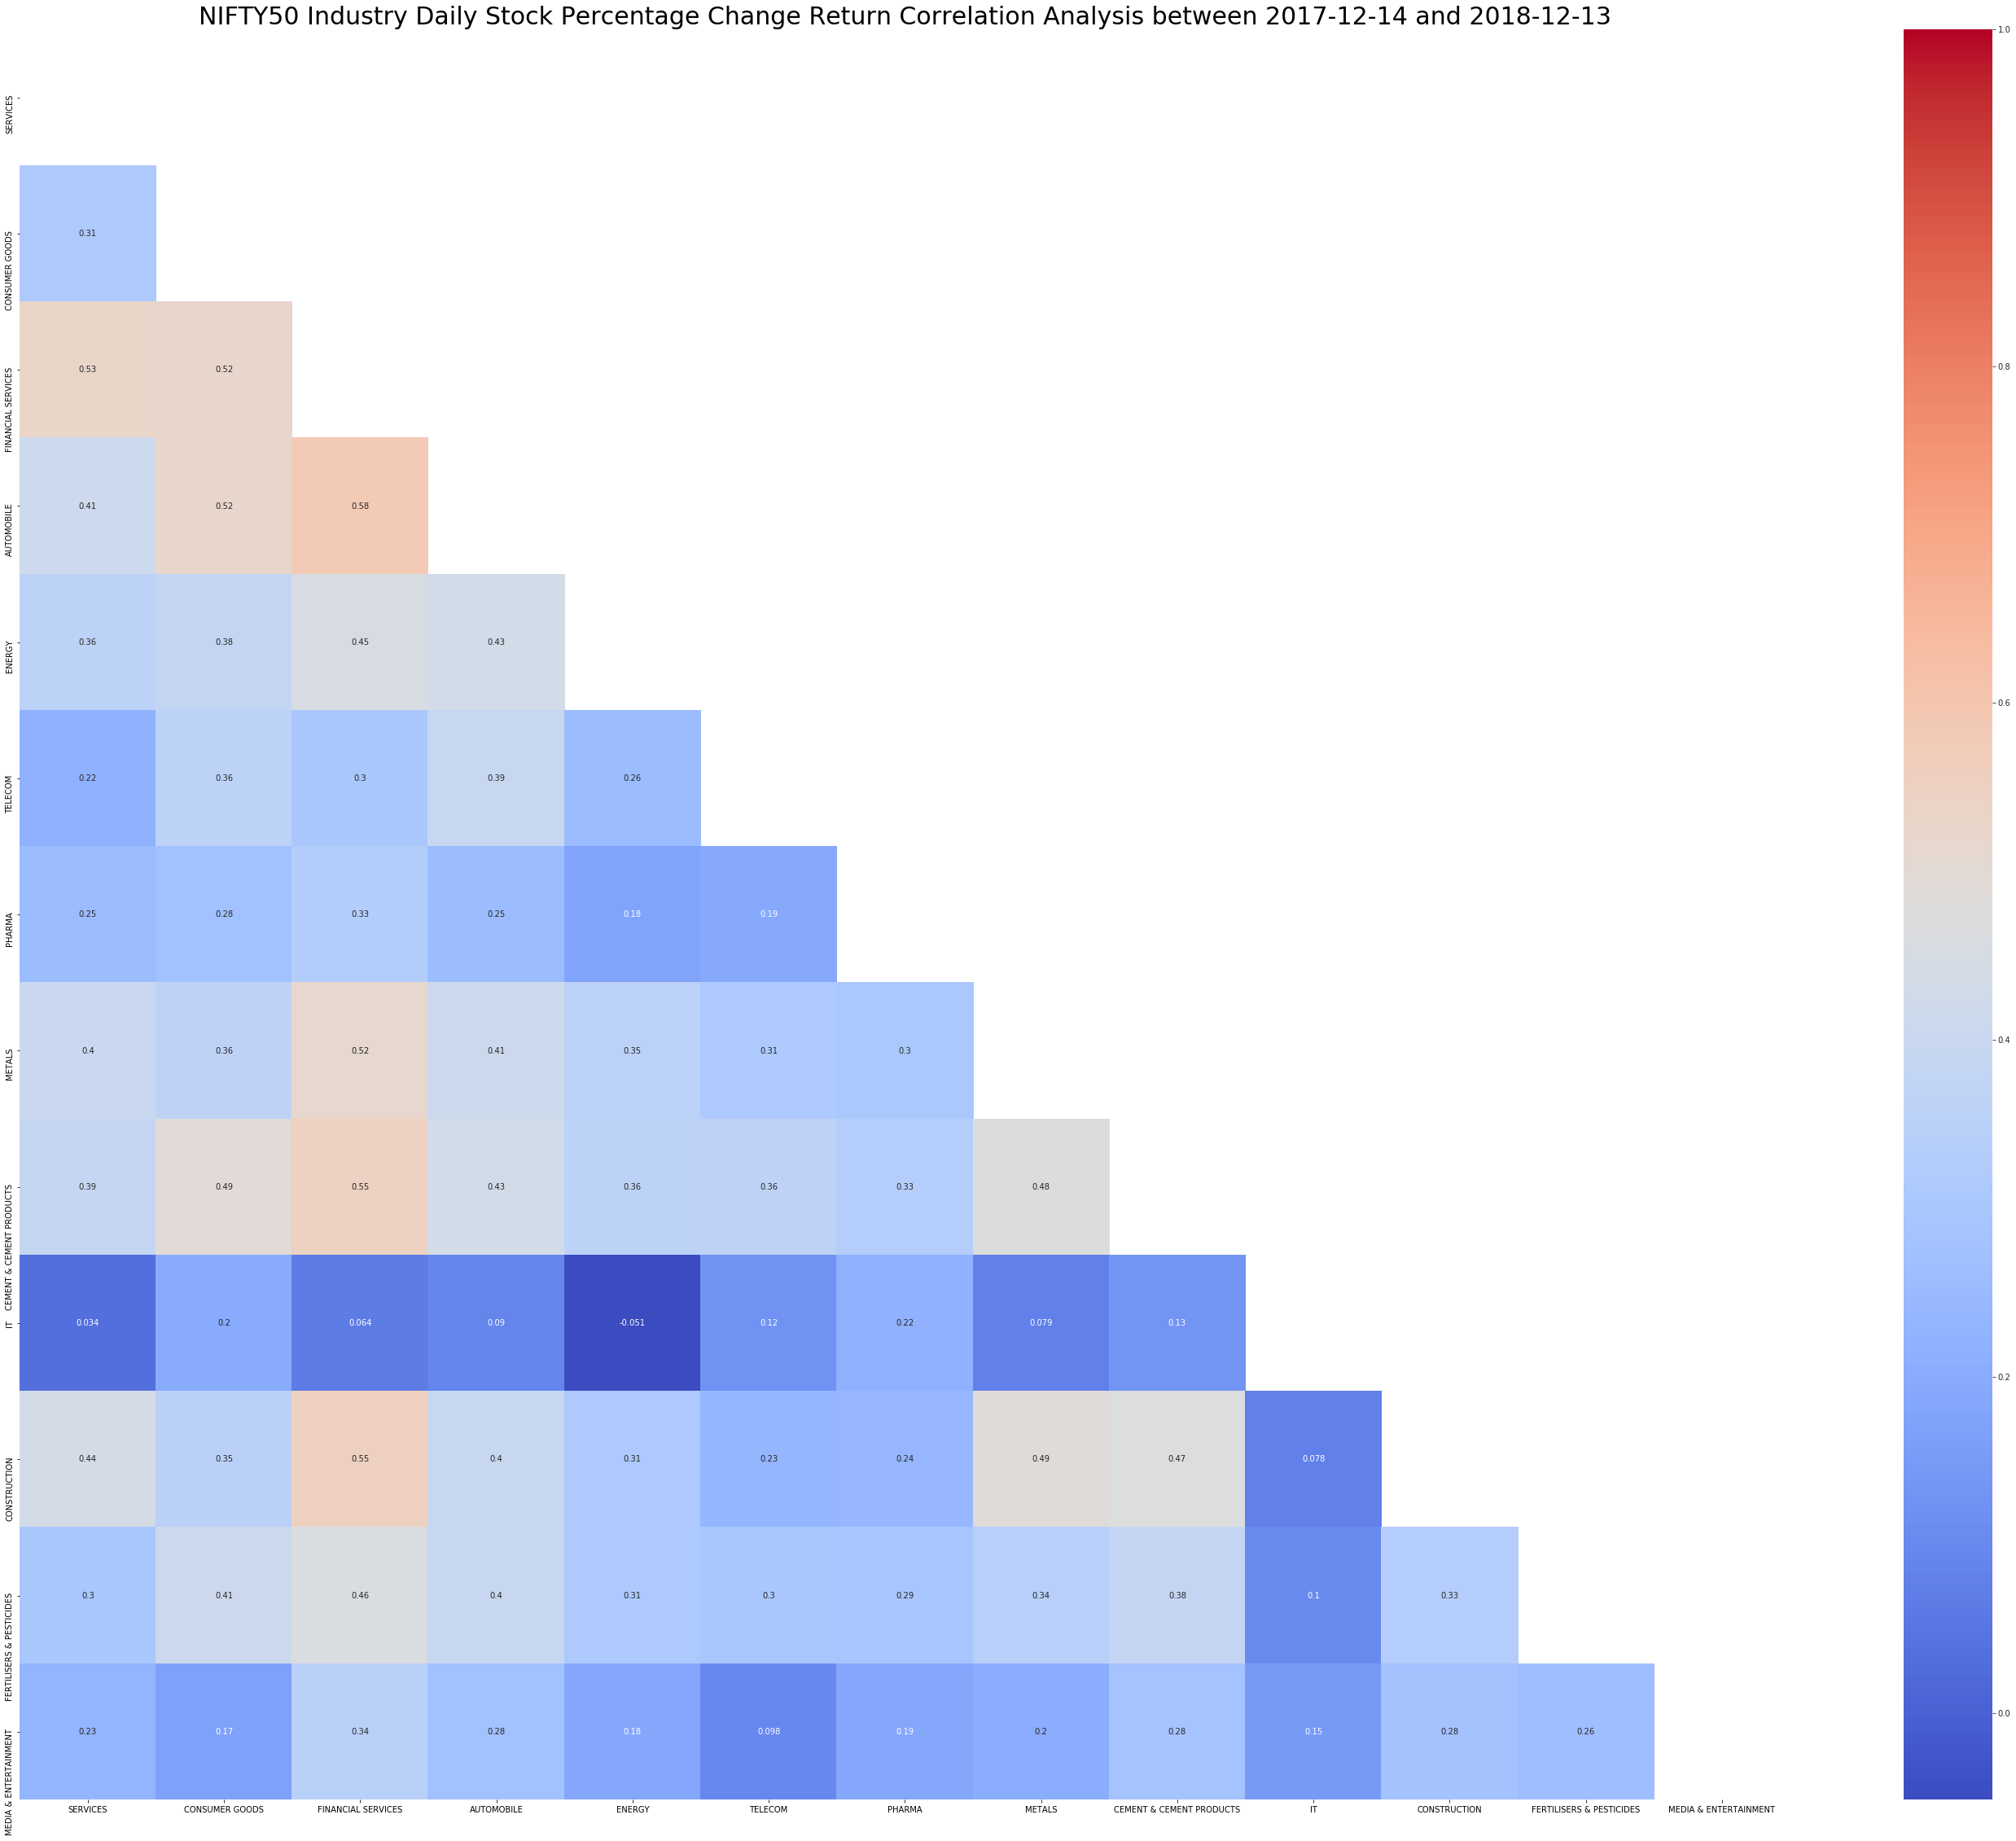

In [32]:
%%time
fig, ax = plt.subplots(figsize=(50,40)) # figsize in inches

ax.set_title("NIFTY50 Industry Daily Stock Percentage Change Return Correlation Analysis between {start} and {end}".format(start=start_date, end=end_date), fontsize=30)

industry_data_frame_corr = industry_data_frame.corr()

mask = np.zeros_like(industry_data_frame_corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(industry_data_frame_corr, annot=True, cmap="coolwarm", mask=mask, square=True)

fig.savefig("NIFTY50IndustryCorrelationMatrix.png", dpi=300)

## Furtner Reading

[Why Correlation Doesn't Matter Much](https://www.forbes.com/sites/rickferri/2014/01/27/why-correlation-doesnt-matter-much/#641c399b3d53)

### Common Mistakes with Correlation

The single most common mistake is assuming a correlation approaching +/- 1 is statistically significant.  A reading approaching +/- 1 definitely increases the chances of actual statistical significance, but without further testing it's impossible to know. The statistical testing of a correlation can get complicated for a number of reasons; it's not at all straightforward.  A critical assumption of correlation is that the variables are independent and that the relationship between them is linear. In theory, you would test these claims to determine if a correlation calculation is appropriate.  

The second most common mistake is forgetting to normalize the data into a common unit.  If calculating a correlation on two betas, then the units are already normalized: beta itself is the unit.  However, if you want to correlate stocks, it's critical you normalize them into percent return, and not share price changes.  This happens all too frequently, even among investment professionals.  

For stock price correlation, you are essentially asking two questions: What is the return over a certain number of periods, and how does that return correlate to another security's return over the same period?  This is also why correlating stock prices is difficult: Two securities might have a high correlation if the return is daily percent changes over the past 52 weeks, but a low correlation if the return is monthly changes over the past 52 weeks.  Which one is "better"? There really is no perfect answer, and it depends on the purpose of the test. 

[Source](https://www.investopedia.com/ask/answers/031015/how-can-you-calculate-correlation-using-excel.asp)

For pairs trading, we need co-integration, not correlation.

## Disclaimer

GNU General Public License v3.0

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.